This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Pre-Processing

In [2]:
df, basin_idx, catchment_idx, coords = read_data(file_dir='../data/hierarchical_septics_v3.csv',
        cols=['ppt_2013', 'water_dist', 'hydraulic_c','median_hse', 'dem', 'flow'], is_balanced=True, is_multilevel=True)

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...


# Multilevel Bayesian Model

- Group septic systems based on their sub-basin (~1560) and basin (~380) levels
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

## Empirical Distributions
Empirical analysis for 

1. distance to water bodies, precipitation: `01 hierarchical_bayesian_twovars`
2. soil hydraulic conductivity: `02 hierarchical_bayesian_threevars`
3. housing values: `03 hierarchical_bayesian_housing`


\begin{equation*}
Y_{i} \sim Bernoulli(\theta_{i})\tag{8}
\end{equation*}

\begin{equation*}
\theta_{i} = \sigma(\beta_{c,i} + \beta_{w,i}.waterdist + \beta_{p,i}.precip + \beta_{h,i}.hydraulics + \beta_{s,i}.hseval + \beta_{t,i}.elev) \tag{9}
\end{equation*}

\begin{equation*}
\overline{f_{i}} = \frac{\sum_{j \in J}f_{i,j}}{|J|} \tag{10}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c,i} \sim N_{c,i}(\mu=\overline{\mu_{c,i}}, \sigma=\overline{\theta_{c,i}})\\
    \text{where }\mu_{c,i,j} \sim N_{c,i,j}(\mu=\mu_c, \sigma=10) \quad and \quad \theta_{c,i,j} \sim HN_{c,i,j}(\sigma=\sigma_c)\\
    \text{with priors } \mu_c \sim N(\mu = 0, \sigma = 10) \quad and \quad \sigma_c \sim HN(\sigma = 10)\tag{11}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p,i} \sim N_{p,i}(\mu=\overline{\mu_{p,i}}, \sigma=\overline{\sigma_{p,i}})\\
    \text{where }\mu_{p,i,j} \sim N_{p,i,j}(\mu=\mu_p, \sigma=10)\quad and \quad \sigma_{p,i,j} \sim HN_{p,i,j}(\sigma=\sigma_p)\\
    \text{with priors } \mu_p \sim N(\mu = 0, \sigma = 10) \quad and \quad \sigma_p \sim HN(\sigma = 10) \tag{12}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h,i} \sim U_{h,i}(lower=-2,upper=\overline{\sigma_{h,i}})\\
    \text{where }\sigma_{h,i,j} \sim HN_{h,i,j}(\sigma=\sigma_h)\\
    \text{with priors } \sigma_h \sim HN(\sigma = 10)\tag{13}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s,i} \sim N_{s,i}(\mu=0, \sigma=\overline{\sigma_{s,i}})\\
    \text{where }\sigma_{s,i,j} \sim HN_{s,i,j}(\sigma=\sigma_s)\\
    \text{with priors } \sigma_s \sim HN(\sigma = 5) \tag{14}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t,i} \sim Exp_{t,i}(\lambda=\overline{\lambda_{t,i}})\\
    \text{where }\lambda_{t,i,j} \sim HN_{t,i,j}(\sigma=\sigma_t)\\
    \text{with priors }\sigma_t \sim HN(\sigma=5)\tag{15}
\end{equation*}

In [4]:
with pm.Model(coords=coords) as model:
    print('fitting full 2-level Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    wtr_beta_c = pm.HalfNormal("wtr_beta_c", sigma=wtr_beta, dims='catchment')
    ppt_mu_c = pm.Normal("ppt_mu_c", mu=ppt_mu, sigma=10, dims='catchment')
    ppt_sig_c = pm.HalfNormal("ppt_sig_c", sigma=ppt_sig, dims='catchment')
    hydr_sig_c = pm.HalfNormal('hydr_sig_c', sigma=hydr_sig, dims='catchment')
    hse_sig_c = pm.HalfNormal('hse_sig_c', sigma=hse_sig, dims='catchment')
    dem_beta_c = pm.HalfNormal('dem_beta_c', sigma=dem_beta)
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta_c.mean(), dims="basin")
    ppt = pm.Normal("ppt", mu=ppt_mu_c.mean(), sigma=ppt_sig_c.mean(), dims="basin")
    hydr = pm.Uniform('hydr', lower=-2, upper=hydr_sig_c.mean(), dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig_c.mean(), dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta_c.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=350, cores=4, return_inferencedata=True, target_accept=0.99)

fitting full 2-level Bayesian model...


/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: invalid value encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, hse, hydr, ppt, wtr_dist, sigma_inter_c, mu_inter_c, dem_beta_c, hse_sig_c, hydr_sig_c, ppt_sig_c, ppt_mu_c, wtr_beta_c, sigma_inter, mu_inter, dem_beta, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta]


Sampling 4 chains for 350 tune and 500 draw iterations (1_400 + 2_000 draws total) took 55 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9662995980729361, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
graph = pm.model_to_graphviz(model)
graph.render(filename='../docs/double_level')

'../docs/double_level.pdf'

In [10]:
# evaluate model (just dem)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

accuracy is: 91.45962732919256%


# Evaluation

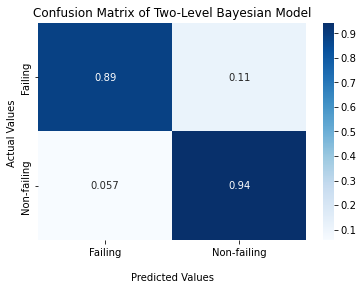

In [11]:
plot_confusion(y, y_pred, title='Confusion Matrix of Two-Level Bayesian Model')